In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [67]:
# user_input = input("Enter the date in YYYY-MM-DD format: ")
# selected_date = pd.to_datetime(user_input, format='%Y-%m-%d')
# selected_data = data[data['time'].dt.date == selected_date.date()]

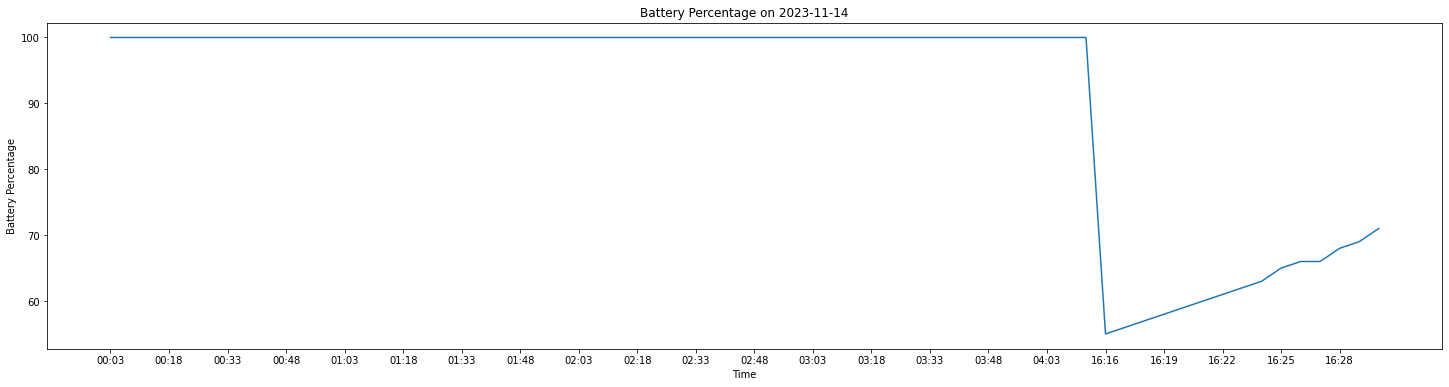

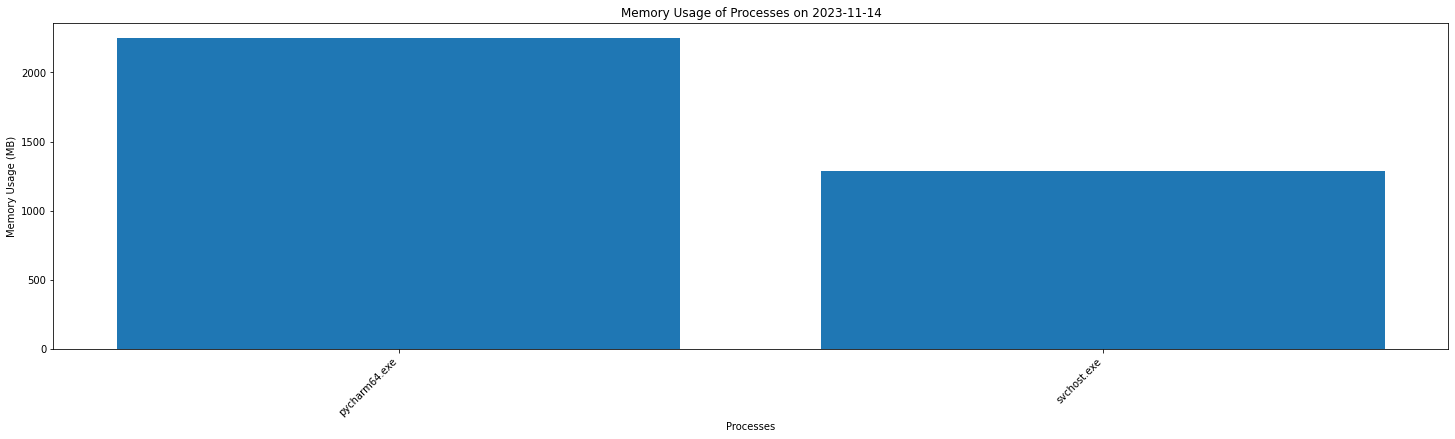

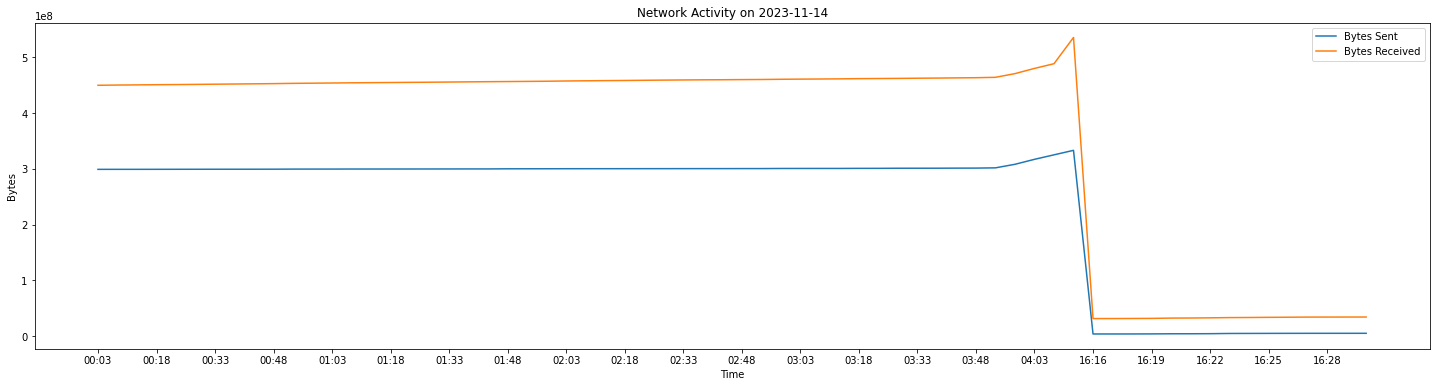

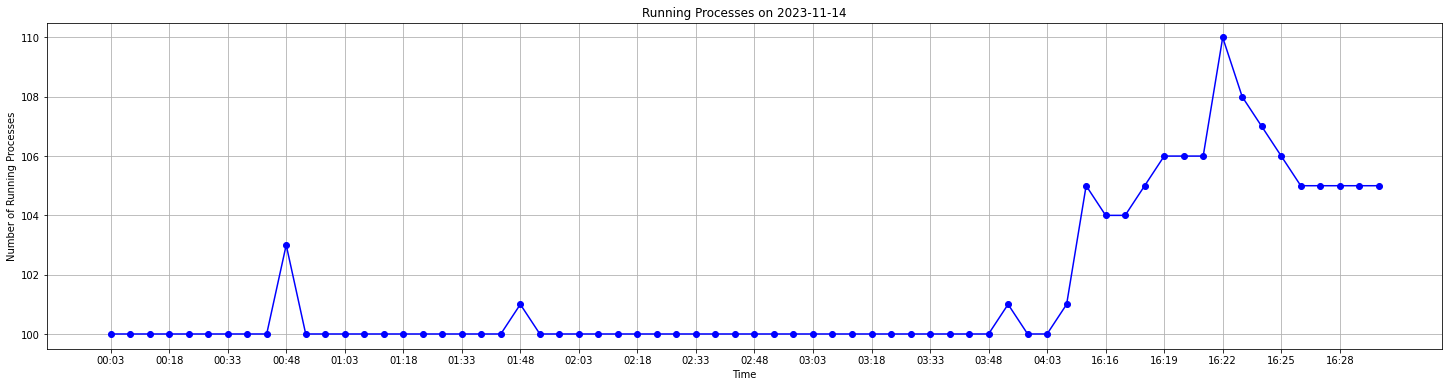

In [68]:
data = pd.read_csv('Reports/FullReport.csv')

data['time'] = pd.to_datetime(data['time'], unit='s')

# Ask the user to choose the date
user_choice = input("Enter 'today' for today's date, or enter a date in YYYY-MM-DD format: ")

if user_choice.lower() == 'today':
    selected_date = pd.to_datetime('today').date()
else:
    try:
        selected_date = pd.to_datetime(user_choice, format='%Y-%m-%d').date()
    except ValueError:
        print("Invalid date format. Please enter 'today' or a valid date in the format YYYY-MM-DD.")
        sys.exit(1)

# Filter data for the selected date
selected_data = data[data['time'].dt.date == selected_date]

# Now update the 'time' column in the selected_data DataFrame
selected_data = selected_data.assign(
    time=selected_data['time'].dt.strftime('%H:%M')
)

# Check if data is available for the selected date
if selected_data.empty:
    print(f"No data available for the selected date ({selected_date}). Please choose another date.")
    sys.exit(1)

# Choose the number of intervals to display on the X-axis
max_intervals = 20

# Calculate the step size to skip data points
step_size = max(1, len(selected_data) // max_intervals)

# Extract the subset of data for X-axis labels
x_labels_data = selected_data.iloc[::step_size]

# Plotting Battery Percentage
plt.figure(figsize=(25, 6))
plt.plot(selected_data['time'].values, selected_data['batteryPercent'].values)
plt.xticks(x_labels_data['time'].values, x_labels_data['time'].values)
plt.xlabel('Time')
plt.ylabel('Battery Percentage')
plt.title(f'Battery Percentage on {selected_date.strftime("%Y-%m-%d")}')
plt.show()

# Plotting Memory Usage of Processes
# REVIEW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.figure(figsize=(25, 6))
data_sorted_by_mem = selected_data.sort_values(by='memUsageMB', ascending=False)
plt.bar(data_sorted_by_mem['hungriestProc'].values, data_sorted_by_mem['hungryProcMem'].values)
plt.xlabel('Processes')
plt.ylabel('Memory Usage (MB)')
plt.title(f'Memory Usage of Processes on {selected_date.strftime("%Y-%m-%d")}')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting Network Activity
plt.figure(figsize=(25, 6))
plt.plot(selected_data['time'].values, selected_data['bytesSent'].values, label='Bytes Sent')
plt.plot(selected_data['time'].values, selected_data['bytesReceived'].values, label='Bytes Received')
plt.xticks(x_labels_data['time'].values, x_labels_data['time'].values)
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.title(f'Network Activity on {selected_date.strftime("%Y-%m-%d")}')
plt.legend()
plt.show()

#Plotting Running Processes
plt.figure(figsize=(25, 6))
plt.plot(selected_data['time'].values, selected_data['runningProc'].values, marker='o', linestyle='-', color='b')
plt.xticks(x_labels_data['time'].values, x_labels_data['time'].values)
plt.xlabel('Time')
plt.ylabel('Number of Running Processes')
plt.title(f'Running Processes on {selected_date.strftime("%Y-%m-%d")}')
plt.grid(True)
plt.show()

In [69]:
# # Analysis :
# # Battery Analysis
# average_battery = selected_data['batteryPercent'].mean()
# min_battery = selected_data['batteryPercent'].min()
# max_battery = selected_data['batteryPercent'].max()
#
# # Memory Usage Analysis
# total_mem_usage = selected_data['memUsageMB'].sum()
# top_processes = data_sorted_by_mem.head(5)  # Adjust the number as needed
#
# # Network Activity Analysis
# total_bytes_sent = selected_data['bytesSent'].sum()
# total_bytes_received = selected_data['bytesReceived'].sum()
#
# # Running Processes Analysis
# average_running_processes = selected_data['runningProc'].mean()
#
# # Charging Analysis
# selectedDate = selected_data['charging'].astype(bool)
#
# charging_percentage = (selectedDate.sum() / len(selectedDate)) * 100
#
# # Connected Analysis
# connected_percentage = (selectedDate.sum() / len(selectedDate)) * 100
#
# # Process Analysis
# top_running_processes = selected_data['runningProc'].mode()
#
# # Hungry Process Analysis
# top_hungry_process = selected_data.loc[selected_data['memUsageMB'].idxmax()]
#
# # Memory Usage Trends
# memory_trends = selected_data[['time', 'memUsageMB']]
# memory_trends.set_index('time', inplace=True)
#
# # Resample data for a smoother trend
# memory_trends_resampled = memory_trends.resample('H').mean()
#
# # Displaying Results with Improved Formatting
# # Battery Analysis
# print("\nBattery Analysis:")
# print(f"  Average Battery Percentage: {average_battery:.2f}%")
# print(f"  Minimum Battery Percentage: {min_battery:.2f}%")
# print(f"  Maximum Battery Percentage: {max_battery:.2f}%")
#
# # Memory Usage Analysis
# print("\nMemory Usage Analysis:")
# print(f"  Total Memory Usage: {total_mem_usage:.2f} MB")
# print("\nTop Processes by Memory Usage:")
# print(top_processes[['hungriestProc', 'memUsageMB']].to_string(index=False))
#
# # Network Activity Analysis
# print("\nNetwork Activity Analysis:")
# print(f"  Total Bytes Sent: {total_bytes_sent} bytes")
# print(f"  Total Bytes Received: {total_bytes_received} bytes")
#
# # Running Processes Analysis
# print("\nRunning Processes Analysis:")
# print(f"  Average Number of Running Processes: {average_running_processes:.2f}")
#
# # Charging and Connected Analysis
# print("\nCharging and Connected Analysis:")
# print(f"  Percentage of Time Charging: {charging_percentage:.2f}%")
# print(f"  Percentage of Time Connected: {connected_percentage:.2f}%")
#
# # Process Analysis
# print("\nProcess Analysis:")
# print("  Most Frequently Running Processes:")
# print(top_running_processes.to_string(index=False))
#
# # Hungry Process Analysis
# print("\nHungry Process Analysis:")
# print("  Process with Highest Memory Usage:")
# print(top_hungry_process[['hungriestProc', 'memUsageMB']].to_string(index=False))
#
# # Memory Usage Trends
# print("\nMemory Usage Trends:")
# print(memory_trends_resampled.to_string())